# Universidad Nacional de Córdoba
# DIPLODATOS - Facultad de Matemática, Astronomía, Física y Computación

## Trabajo Práctico Número 1 (Analisis del archivo exercise_2.py) - Uso de Embeddings

Autores: 
* Diaz Cobos Facundo
* Epifanio Luis
* Gonzalez Leonardo David
* Gualpa Mariano Martín




# 1. Consigna del Ejercicio 1.

1. Procesar el conjunto de datos para obtener una representación basada en embeddings de palabras de cada revisión. Pueden utilizar cualquier wordvector, pero les recomendamos FastText.

Estamos utilizando una versión filtrada de FastText, donde sólo incluímos las palabras en el vocabulario del dataset de movies. Para más información, ver el script `filter_fasttext.py`.

2. Repetir los pasos 2 a 4 del ejercicio 1

 (Copia de los puntos del ejercicio 1)

 2.2. Construir un pipeline de clasificación con un modelo Keras NLP.

 2.3. Entrenar uno o varios modelos (con dos o tres es suficiente, veremos más de esto en el práctico 2). Evaluar los  modelos en el conjunto de test.

 2.4. Reportar los hyperparámetros y resultados de todos los modelos entrenados. Para esto, pueden utilizar una notebook o un archivo (pdf|md). Dentro de este reporte tiene que describir:
  * Hyperparámetros con los que procesaron el dataset: tamaño del vocabulario, normalizaciones, etc.
  * Las decisiones tomadas al construir cada modelo: regularización, dropout, número y tamaño de las capas, optimizador.
  * Proceso de entrenamiento: división del train/test, tamaño del batch, número de épocas, métricas de evaluación. Seleccione los mejores hiperparámetros en función de su rendimiento. El proceso de entrenamiento debería ser el mismo para todos los modelos.
  * (Punto estrella) Analizar si el clasificador está haciendo overfitting. Esto se puede determinar a partir del resultado del método fit.

# 2. Desarrollo.

## 2.1. Carga de Librerías y Funciones 

In [0]:
#!wget --continue https://github.com/david-gonzalez/aprendizaje-profundo/raw/master/dataset/txt_sentoken.zip
#!mkdir dataset && mv txt_sentoken.zip ./dataset
#!cd dataset && unzip txt_sentoken.zip


#!wget --continue https://github.com/david-gonzalez/aprendizaje-profundo/raw/master/filtered_wiki-news-300d-50k.vec.zip
#!unzip filtered_wiki-news-300d-50k.vec.zip

#!wget --continue https://github.com/david-gonzalez/aprendizaje-profundo/raw/master/utils.py
#!wget --continue https://github.com/david-gonzalez/aprendizaje-profundo/raw/master/printutils.py

In [2]:
import argparse
import keras.backend as K
# K is just another name for the keras backend: tensorflow (or theaso,
# if you are using a different backend).
import pandas
import pickle

from keras.layers import Embedding, Average, Lambda
from keras.models import Sequential
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from utils import FilteredFastText
import matplotlib.pyplot as plt


import numpy as np
import datetime
import os

from tensorflow.python.keras.utils import np_utils   # for tf 1.3.1
#from tensorflow.python.keras import utils as np_utils     # for tf 1.4.1

from keras.models import Sequential, Model 
from keras.layers import Dense, Activation, Dropout, GlobalAveragePooling1D, Input
#from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling1D
from keras import optimizers, regularizers


from itertools import repeat
from IPython.display import display, HTML

from printutils import print_message, print_new_process, print_end


Using TensorFlow backend.


In [0]:

def read_args():
    parser = argparse.ArgumentParser(description='Exercise 2')
    # Here you have some examples of classifier parameters. You can add
    # more arguments or change these if you need to.
    parser.add_argument('--num_units', nargs='+', default=[100], type=int,
                        help='Number of hidden units of each hidden layer.')
    parser.add_argument('--dropout', nargs='+', default=[0.5], type=float,
                        help='Dropout ratio for every layer.')
    parser.add_argument('--batch_size', type=int, default=32,
                        help='Number of instances in each batch.')
    parser.add_argument('--experiment_name', type=str, default=None,
                        help='Name of the experiment, used in the filename'
                             'where the results are stored.')
    parser.add_argument('--embeddings_filename', type=str,
                        help='Name of the file with the embeddings.')

    # New parameters:    
    parser.add_argument('--model', type=int, default=10, help='Number of model to run')
    parser.add_argument('--epochs', type=int, default=10, help='Number of epochs')
    parser.add_argument('--shuffle', type=str, default='batch', help='Shuffle value')
    parser.add_argument('--random_seed', type=int, default=10, help='Random seed number')
    parser.add_argument('--verbose', type=int, default=1, help='Verbose info on screen')
    
    # parse parameters
    if arguments == None:
        args = parser.parse_args()
    else:
        args = parser.parse_args(arguments)

    assert len(args.num_units) == len(args.dropout)
    return args



## 2.2. Procesar el conjunto de datos utilizando FastText.

__Responde al punto:__

_1. Procesar el conjunto de datos para obtener una representación basada en embeddings de palabras de cada revisión. Pueden utilizar cualquier wordvector, pero les recomendamos FastText._

_Estamos utilizando una versión filtrada de FastText, donde sólo incluímos las palabras en el vocabulario del dataset de movies. Para más información, ver el script `filter_fasttext.py`._



In [0]:
def load_dataset():
    dataset = load_files('dataset/txt_sentoken', shuffle=False)

    X_train, X_test, y_train, y_test = train_test_split(
        dataset.data, dataset.target, test_size=0.25, random_state=42)

    print('Training samples {}, test_samples {}'.format(
        len(X_train), len(X_test)))

    return X_train, X_test, y_train, y_test




In [0]:
from keras.preprocessing.sequence import pad_sequences


def transform_input(instances, mapping):
    """Replaces the words in instances with their index in mapping.

    Args:
        instances: a list of text instances.
        mapping: an dictionary from words to indices.

    Returns:
        A matrix with shape (n_instances, max_text_length)."""
    word_indices = []
    for instance in instances:
        word_indices.append([mapping[word.decode('utf-8')]
                             for word in instance.split()])
    # Check consistency
    assert len(instances[0].split()) == len(word_indices[0])

    # Pad the sequences to obtain a matrix instead of a list of lists.
    return pad_sequences(word_indices)
    


## 2.3. Construir modelos Keras

Se plantean modelos con diferentes arquitecturas para realizar las pruebas:

### Build the Keras models:

### Model 1: 

In [0]:
def build_keras_model_1(filtered_fasttext, args):
    # The input is ready, start the model
    model = Sequential()
    #model.add(Input(shape=(X_train_vectorized.shape[1],)))
    model.add(Embedding(
        filtered_fasttext.wv.shape[0],  # Vocabulary size
        filtered_fasttext.wv.shape[1],  # Embedding size
        weights=[filtered_fasttext.wv],  # Word vectors
        trainable=False,  # This indicates the word vectors must not be changed
                         # during training.
        #input_shape=(X_train_vectorized.shape[1],)
    ))
    
    # The output here has shape
    #     (batch_size (?), words_in_reviews (?), embedding_size)
    # To use a Dense layer, the input must have only 2 dimensions. We need to
    # create a single representation for each document, combining the word
    # embeddings of the words in the intance.
    # For this, we have to use a Tensorflow (K) operation directly.
    # The operation we need to do is to take the average of the embeddings
    # on the second dimension. We wrap this operation on a Lambda
    # layer to include it into the model.
    
    model.add(Lambda(lambda xin: K.mean(xin, axis=1), name='embedding_average'))
    
    # Now the output shape is (batch_size (?), embedding_size)

    # TODO 2: Finish the Keras model
    # Add all the layers
    # ...
    # model.compile(...)
    #input_size = X_train.shape[1]
    #model.add(Dense(args.num_units[0], input_shape=(input_size,)))    

    model.add(Dense(args.num_units[0], activation = 'relu'))    
    
    model.add(Dense(2))
    model.add(Activation('softmax'))
       
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', #optimizers.Adagrad(), 
                  metrics=['accuracy'])
    
    return model


### Model 2: 

In [0]:
def build_keras_model_2(filtered_fasttext, args):
    # The input is ready, start the model
    model = Sequential()
    #model.add(Input(shape=(X_train_vectorized.shape[1],)))
    model.add(Embedding(
        filtered_fasttext.wv.shape[0],  # Vocabulary size
        filtered_fasttext.wv.shape[1],  # Embedding size
        weights=[filtered_fasttext.wv],  # Word vectors
        trainable=False,  # This indicates the word vectors must not be changed
                         # during training.
        #input_shape=(X_train_vectorized.shape[1],)
    ))
    
    # The output here has shape
    #     (batch_size (?), words_in_reviews (?), embedding_size)
    # To use a Dense layer, the input must have only 2 dimensions. We need to
    # create a single representation for each document, combining the word
    # embeddings of the words in the intance.
    # For this, we have to use a Tensorflow (K) operation directly.
    # The operation we need to do is to take the average of the embeddings
    # on the second dimension. We wrap this operation on a Lambda
    # layer to include it into the model.
    
    model.add(Lambda(lambda xin: K.mean(xin, axis=1), name='embedding_average'))
    
    # Now the output shape is (batch_size (?), embedding_size)

    # TODO 2: Finish the Keras model
    # Add all the layers
    # ...
    # model.compile(...)
    #input_size = X_train.shape[1]
    #model.add(Dense(args.num_units[0], input_shape=(input_size,)))    

    model.add(Dense(args.num_units[0], activation = 'relu'))    

    model.add(Dropout(args.dropout[0]))    

    model.add(Dense(args.num_units[0]//2, activation = 'relu'))    

    model.add(Dense(2))
    model.add(Activation('softmax'))
     
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', #optimizers.Adagrad(), 
                  metrics=['accuracy'])
    
    return model



## 2.4. Entrenamiento del Modelo

In [0]:
def plot_model_history(model_history):
   fig, axs = plt.subplots(1,2,figsize=(15,5))
   # summarize history for accuracy
   axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
   #axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
   axs[0].set_title('Model Accuracy')
   axs[0].set_ylabel('Accuracy')
   axs[0].set_xlabel('Epoch')
   axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
   axs[0].legend(['train'], loc='best')
   # summarize history for loss
   axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
   #axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
   axs[1].set_title('Model Loss')
   axs[1].set_ylabel('Loss')
   axs[1].set_xlabel('Epoch')
   axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
   axs[1].legend(['train'], loc='best')
   plt.show()
   


### 2.4.1. Main:

Función principal que llama a las rutinas anteriores para realizar el entrenamiento. 

__Responde al punto:__

_2. Construir un pipeline de clasificación con un modelo Keras NLP._

In [0]:
def main():
    # Load params
    args = read_args()

    # Get datetime of experiment.
    experiment_number = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

    # Configurar semilla para facilitar reproducibilidad.
    np.random.seed(args.random_seed)
    
    # Load dataset    
    X_train, X_test, y_train, y_test_orginal = load_dataset()

    # Convert the labels to categorical
    num_classes = 2 
    y_train_cat = np_utils.to_categorical(y_train, num_classes)    
    y_test_cat = np_utils.to_categorical(y_test_orginal, num_classes)    

    # Verify balance of labels in train and test
    # Print count frequency of labels in train and test. 
    #print(np.bincount(y_train))
    #print(np.bincount(y_test_orginal))
    
    # Load the filtered FastText word vectors, using only the vocabulary in
    # the movie reviews dataset
    with open(args.embeddings_filename, 'rb') as model_file:
        filtered_fasttext = pickle.load(model_file)

    # The next thing to do is to choose how we are going to represent our
    # training matrix. Each review must be translated into a single vector.
    # This means we have to combine, somehow, the word vectors of each
    # word in the review. Some options are:
    #  - Take the average of all vectors.
    #  - Take the minimum and maximum value of each feature.
    # All these operations are vectorial and easier to compute using a GPU.
    # Then, it is better to put them inside the Keras model.

    # The Embedding layer will be quite handy in solving this problem for us.
    # To use this layer, the input to the network has to be the indices of the
    # words on the embedding matrix.
    

    X_train_vectorized = transform_input(X_train, filtered_fasttext.word2index)
    X_test_vectorized = transform_input(X_test, filtered_fasttext.word2index)


    word_indices = []
    for instance in X_train:
        word_indices.append([filtered_fasttext.word2index[word.decode('utf-8')]
                             for word in instance.split()])
    # Check consistency
    assert len(X_train[0].split()) == len(word_indices[0])
    word_indices = np.array(word_indices)
     
    
    print_new_process('Build Model:', args )
    # TODO 3: Build the Keras model
    switcher = {
        1: build_keras_model_1,
        2: build_keras_model_2
    }
    # Get the function from switcher dictionary
    model_builder = switcher.get(args.model, lambda: "nothing")

    model = model_builder(filtered_fasttext, args)

    

    # Show model info on screen
    print_message('MODEL:', args )
    print_message( model.summary(), args )


    
    


    # TODO 3: Fit the model
    # hitory = model.fit(batch_size=??, ...)
    print_new_process('Fit:', args)
    history = model.fit(X_train_vectorized, y_train_cat,
                        batch_size=args.batch_size,
                        epochs=args.epochs,
                        shuffle=args.shuffle,
#                        validation_data=(X_test_vectorized, y_test_cat), 
                        verbose=1,
#                        validation_split=0.60
             )
    
    # plot model history
    plot_model_history(history)


    
    # TODO 4: Evaluate the model, calculating the metrics.
    # Option 1: Use the model.evaluate() method. For this, the model must be
    # already compiled with the metrics.
    # performance = model.evaluate(transform_input(X_test), y_test)

    # Option 2: Use the model.predict() method and calculate the metrics using
    # sklearn. We recommend this, because you can store the predictions if
    # you need more analysis later. Also, if you calculate the metrics on a
    # notebook, then you can compare multiple classifiers.
    # predictions = ...
    # performance = ...

    
    print_new_process('Predictions:',args)
    predictions = model.predict_classes(X_test_vectorized, verbose=1)
    
    if args.verbose == 1:
        display( str(list(predictions)))

    print_new_process('Test:',args)
    if args.verbose == 1:        
        display( str(list(y_test_orginal)))
 
    print_new_process('Performance:',args)
    score, accuracy = model.evaluate(X_test_vectorized, y_test_cat)
    print_message( '[score, accuracy]', args )
    print_message( [score, accuracy], args )
    
    # TODO 5: Save the results.
    # ...
    parameters_path = 'results/parameters/'
    if not os.path.exists(parameters_path):
        os.makedirs(parameters_path)
    predictions_path = 'results/predictions/'
    if not os.path.exists(predictions_path):
        os.makedirs(predictions_path)

    parameters_filename = 'results/parameters/parameters_{0}_acc_{1:.6f}.csv'.format( experiment_number, accuracy )
    print_new_process('Saving parameters: {}'.format(parameters_filename),args)  
    
    parameters_df = pandas.DataFrame(columns=['Parameter','Value'])
    for k,v in sorted(vars(args).items()):
        row = pandas.Series([str(k), str(v)], index=['Parameter', 'Value'])
        parameters_df = parameters_df.append(row,ignore_index=True)
    parameters_df.to_csv(parameters_filename, index=False )
    
    predictions_filename = 'results/predictions/predictions_{0}_acc_{1:.6f}.csv'.format( experiment_number, accuracy )
    print_new_process('Saving predictions: {}'.format(predictions_filename),args)  
    predictions_df = pandas.DataFrame(y_test_orginal, columns=['true_label'])
    predictions_df.loc[:, 'predicted'] = predictions
    predictions_df.to_csv( predictions_filename, index=False )
    
    print_message('Done.',args)    
    print_end('STOP.',args)    
    
    
    # One way to store the predictions:
    """
    results = pandas.DataFrame(y_test_orginal, columns=['true_label'])
    results.loc[:, 'predicted'] = predictions
    results.to_csv('predicitions_{}.csv'.format(args.experiment_name),
                   index=False)
    """



#if __name__ == '__main__':
#    main()



### 2.4.2. Ejecución del modelo:

__Responde al punto:__

_3. Entrenar uno o varios modelos (con dos o tres es suficiente, veremos más de esto en el práctico 2). Evaluar los modelos en el conjunto de test._

Training samples 1500, test_samples 500
2018-12-12 05:19:54 ------------------------------------------------------------------------
2018-12-12 05:19:54 - Build Model:
2018-12-12 05:19:55 - MODEL:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         15276000  
_________________________________________________________________
embedding_average (Lambda)   (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              308224    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 15,586,274
Trainable params: 310,274
Non-trainable params: 15,2

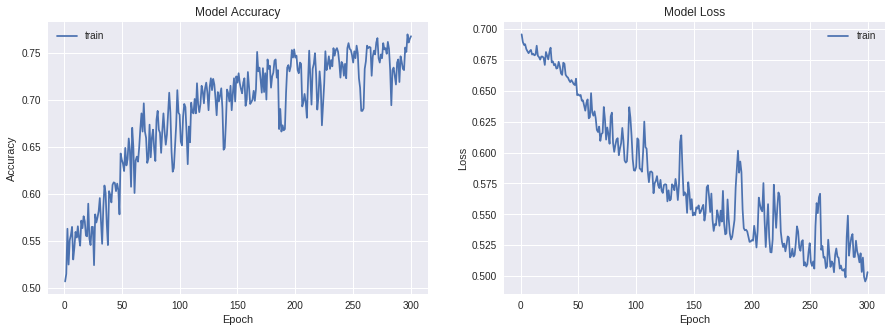

2018-12-12 05:21:00 ------------------------------------------------------------------------
2018-12-12 05:21:00 - Predictions:
500/500 [==============================] - 0s 212us/step


'[1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,

2018-12-12 05:21:00 ------------------------------------------------------------------------
2018-12-12 05:21:00 - Test:


'[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,

2018-12-12 05:21:00 ------------------------------------------------------------------------
2018-12-12 05:21:00 - Performance:
500/500 [==============================] - 0s 187us/step
2018-12-12 05:21:00 - [score, accuracy]
2018-12-12 05:21:00 - [0.5882471470832825, 0.7099999990463257]
2018-12-12 05:21:00 ------------------------------------------------------------------------
2018-12-12 05:21:00 - Saving parameters: results/parameters/parameters_20181212051952_acc_0.710000.csv
2018-12-12 05:21:00 ------------------------------------------------------------------------
2018-12-12 05:21:00 - Saving predictions: results/predictions/predictions_20181212051952_acc_0.710000.csv
2018-12-12 05:21:00 - Done.
2018-12-12 05:21:00 ------------------------------------------------------------------------
2018-12-12 05:21:00 - STOP.
2018-12-12 05:21:00 ------------------------------------------------------------------------


In [10]:
# cargamos argumentos de prueba
arguments = ['--model=1',
             '--num_units=1024',
             '--dropout=0.20',
             '--batch_size=200', 
             '--embeddings_filename=filtered_wiki-news-300d-50k.vec',
             '--epochs=300',
             '--shuffle=batch',
             '--random_seed=10',
             '--verbose=1'
            ]


# Ejecutamos el procedimiento principal
main()

Training samples 1500, test_samples 500
2018-12-12 05:22:19 ------------------------------------------------------------------------
2018-12-12 05:22:19 - Build Model:
2018-12-12 05:22:19 - MODEL:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         15276000  
_________________________________________________________________
embedding_average (Lambda)   (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 768)               231168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 384)               295296    
_________________________________________________________________
dense_5 (De

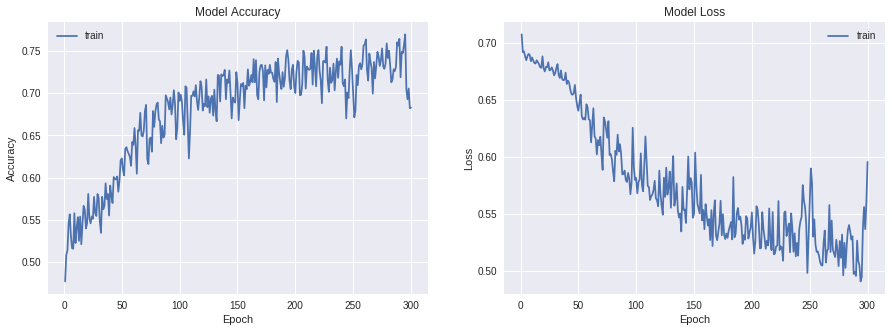

2018-12-12 05:23:27 ------------------------------------------------------------------------
2018-12-12 05:23:27 - Predictions:
500/500 [==============================] - 0s 246us/step


'[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,

2018-12-12 05:23:27 ------------------------------------------------------------------------
2018-12-12 05:23:27 - Test:


'[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,

2018-12-12 05:23:27 ------------------------------------------------------------------------
2018-12-12 05:23:27 - Performance:
500/500 [==============================] - 0s 233us/step
2018-12-12 05:23:27 - [score, accuracy]
2018-12-12 05:23:27 - [0.7474321570396424, 0.6340000009536744]
2018-12-12 05:23:27 ------------------------------------------------------------------------
2018-12-12 05:23:27 - Saving parameters: results/parameters/parameters_20181212052218_acc_0.634000.csv
2018-12-12 05:23:27 ------------------------------------------------------------------------
2018-12-12 05:23:27 - Saving predictions: results/predictions/predictions_20181212052218_acc_0.634000.csv
2018-12-12 05:23:27 - Done.
2018-12-12 05:23:27 ------------------------------------------------------------------------
2018-12-12 05:23:27 - STOP.
2018-12-12 05:23:27 ------------------------------------------------------------------------


In [11]:
# cargamos argumentos de prueba
arguments = ['--model=2',
             '--num_units=768',
             '--dropout=0.20',
             '--batch_size=200', 
             '--embeddings_filename=filtered_wiki-news-300d-50k.vec',
             '--epochs=300',
             '--shuffle=batch',
             '--random_seed=10',
             '--verbose=1'
            ]



# Ejecutamos el procedimiento principal
main()

# 3. Reporte 

__Responde al punto:__
_Reportar los hyperparámetros y resultados de todos los modelos entrenados. Para esto, pueden utilizar una notebook o un archivo (pdf|md). Dentro de este reporte tiene que describir:_

* _Hyperparámetros con los que procesaron el dataset: tamaño del vocabulario, normalizaciones, etc._
* _Las decisiones tomadas al construir cada modelo: regularización, dropout, número y tamaño de las capas, optimizador._
* _Proceso de entrenamiento: división del train/test, tamaño del batch, número de épocas, métricas de evaluación._ 
* _Seleccione los mejores hiperparámetros en función de su rendimiento. El proceso de entrenamiento debería ser el mismo
para todos los modelos._
* _(Punto estrella) Analizar si el clasificador está haciendo overfitting. Esto se puede determinar a partir del resultado del método fit._

## 3.1. Reporte de Hiperparámetros

El trabajo se realizó con un conjunto de datos balanceado formado por 2.000 revisiones de IMDB con sus respectivas etiquetas, del cual se utilizaron 1.500 para entrenamiento y 500 para test. 

Respecto a la vectorización,  se utilizó FastText como embedding.

Respecto a la red, se probaron muchos modelos diferentes, de los cuales, posteriormente se seleccionaron dos de referencia que son los presentados en este trabajo.
Los principales hiperparámetros con los que se trabajó, fueron la cantidad de capas, la cantidad de unidades por capa, el porcentaje de dropout. 





## 3.2. Descripción de los Modelos Utilizados

Se describen a continuación los modelos utilizados para el trabajo.

### 3.2.1. Descripción del Modelo 1

Este modelo es el mas simple, tiene inicialmente una capa de embedding cargada con la matriz de pesos de fasttext (acotado a 50.000 palabras). A continuación, tiene una capa Lambda que calcula el promedio de los vectores de embedding correspondientes a las palabras utilizadas como entrada. Sobre esta base se agrega una capa densa de 1024 unidades con activación 'relu' y finalmente una capa de salida con activación softmax de dos clases. El optimizador seleccionado fue adam.

### 3.2.3. Descripción del Modelo 2

Este modelo es mas complejo que el primero, y se basa en apilar capas densas y de dropout. Tiene inicialmente una capa de embedding cargada con la matriz de pesos de fasttext (acotado a 50.000 palabras). A continuación, tiene una capa Lambda que calcula el promedio de los vectores de embedding correspondientes a las palabras utilizadas como entrada. Sobre esta base se agrega una capa densa de 768 unidades con activación 'relu' seguidas de una capa de dropout al 20%. Sobre esta estructura se agrega otra capa densa de 384 unidades con activación 'relu'  y finalmente una capa de salida con activación softmax de dos clases. El optimizador seleccionado fue adam.

## 3.3. Descripción de Proceso de Entrenamiento

En cada caso se ejecutó el mismo proceso de entrenamiento. Inicialmente se carga el dataset, que se divide en conjuntos de entrenamiento y test. A continuación, para el conjunto de entrenamiento se construye una matriz donde cada fila corresponde a una instancia de entrenamiento y en cada columna de la misma se indican los indices que apuntan a la palabra correspondiente en el vocabulario del embedding fasttext. Se procede de igual manera con el conjunto de test.
El modelo de red neuronal parametrizado elegido para la prueba, se ajusta utilizando el conjunto de entrenamiento. Se agregó para la notebook de este informe el gráfico de evolución a través de las épocas, de accuracy y función de pérdida para entrenamiento.
Posteriormente, se predicen los resultados con el conjunto de test para medir el accuracy correspondiente al modelo.
El proceso de entrenamiento implica correr en cada caso un número de epocas donde en cada una se ajusta el modelo con todo el dataset de entrenamiento, de manera que al finalizar cada una, en general se mejorarían los resultados. Por cada epoca, este ajuste se realiza iterando y tomando en cada iteración una cantidad de observaciones igual al batch size.

## 3.4. Selección de los mejores hiperparámetros
Como se explicó en el punto 3.1. se probaron diferentes configuraciones sobre los modelos de redes neuronales, que básicamente consistian en la arquitectura de la red, cantidad de unidades, capas, porcentaje de dropout (en caso de existir) y función lambda.

Los resultados obtenidos fueron para los mejores juegos de parametros en los modelos elegidos:

Accuracy en test del modelo 1: 0.7099999990463257

Accuracy en test del modelo 2: 0.6340000009536744


El resultado fue la selección del primer modelo (`Modelo 1`), que tuvo el mayor accuracy. Este era el modelo mas simple, que sin embargo mostro un mejor desempeño. Le sigue de cerca el  `Modelo 2` cuya mayor complejidad no se tradujo en mejor desempeño, aunque obtuvo un rendimiento del 63%. En ninguno de los casos se observó overfit.



## 3.5. Análisis sobre el Overfitting

Como puede observarse en los gráficos al final de cada ejecución de modelo (ver al final de cada reporte de salida), para los modelos analizados no se observaron casos de overfit.



# 4. Conclusiones

En este trabajo pudimos analizar diferentes configuraciones de redes neuronales para la clasificación de reviews de IMDB utilizando embeddings. No se pudo lograr mejorías respecto al ejercicio anterior respecto a su desempeño. 
Se pudo observar el impacto (muchas veces importante) de los hiperparámetros, y que no siempre las redes mas complejas convergen a mejores resultados. 
Además, pudimos valorar  como afecta la cantidad de épocas a la evolución y la convergencia en un resultado satisfactorio.
Finalmente pudimos comparar diferentes desempeños para realizar la selección del modelo mas conveniente, en este sentido, se observa en las gráficas que la tendencia del accuracy es a aumentar, por lo que podría considerarse un entrenamiento con mayor cantidad de épocas.


